<a href="https://colab.research.google.com/github/neklyud/Samsung-NeuroNetwork-and-Computer-Visison/blob/master/MNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 16384/9912422 [00:00<01:18, 125511.13it/s]

9920512it [00:02, 4075608.04it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 434474.17it/s]
  2%|▏         | 40960/1648877 [00:00<00:04, 382706.97it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2533285.28it/s]                             
8192it [00:00, 171466.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [2]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
X_train.dtype, y_train.dtype


(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [5]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

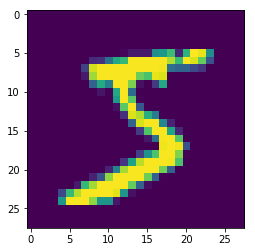

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :,:])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [31]:
torch.cuda.is_available()


False

In [32]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0265, -0.0049,  0.0258,  ..., -0.0219,  0.0263, -0.0246],
         [ 0.0097, -0.0079,  0.0237,  ...,  0.0312,  0.0154,  0.0228],
         [-0.0180,  0.0113,  0.0204,  ..., -0.0239,  0.0097,  0.0053],
         ...,
         [ 0.0114, -0.0017, -0.0042,  ...,  0.0037,  0.0134, -0.0219],
         [ 0.0226,  0.0254, -0.0292,  ..., -0.0085,  0.0151, -0.0015],
         [-0.0230,  0.0333, -0.0202,  ..., -0.0079,  0.0175,  0.0357]],
        requires_grad=True), Parameter containing:
 tensor([-0.0165,  0.0049,  0.0016, -0.0050, -0.0241,  0.0225,  0.0146,  0.0308,
         -0.0063, -0.0259, -0.0164, -0.0327, -0.0028, -0.0160,  0.0009, -0.0257,
          0.0004, -0.0288,  0.0080,  0.0040,  0.0010,  0.0138,  0.0127, -0.0244,
          0.0032,  0.0049,  0.0191,  0.0006,  0.0152, -0.0198, -0.0019, -0.0287,
         -0.0078,  0.0024, -0.0277,  0.0224, -0.0263,  0.0070,  0.0138,  0.0171,
         -0.0264,  0.0180,  0.0008,  0.0331,  0.0176, -0.0225,  0.0096, -0.0077,

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [35]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(1000):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train),batch_size):
    optimizer.zero_grad()
    batch_indexes = order[start_index:start_index+batch_size]
    x_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)
    
    preds = mnist_net.forward(x_batch)
    
    loss_value = loss(preds, y_batch)
    loss_value.backward()
    optimizer.step()
  test_preds = mnist_net.forward(X_test)
  train_preds = mnist_net.forward(X_train)
  test_loss_history.append(loss(test_preds, y_test))
  train_loss_history.append(loss(train_preds, y_train))

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)
  print(accuracy)

tensor(0.9292)
tensor(0.9474)
tensor(0.9492)
tensor(0.9556)
tensor(0.9490)
tensor(0.9606)
tensor(0.9556)
tensor(0.9574)
tensor(0.9585)
tensor(0.9625)
tensor(0.9643)
tensor(0.9575)
tensor(0.9572)
tensor(0.9590)
tensor(0.9576)
tensor(0.9570)
tensor(0.9632)


KeyboardInterrupt: ignored

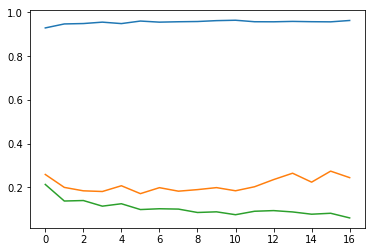

In [37]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);
plt.plot(train_loss_history)

In [39]:
test_train

NameError: ignored